In [1]:
import numpy as np
import os, glob
import gdal, osr # python2.7
# import rasterio # python2.7
# from osgeo import gdal
import MisrToolkit as Mtk # python2.7
from MisrToolkit import * # 

## assumptions

In [2]:
path_num = 180
misr_img_res = (512, 2048)
# img_nrows = misr_img_dims[0]
# img_ncols = misr_img_dims[1]
misr_res_meter = 275
gcp_mode = "corners_n_inside" # 'inside' OR "corners_n_inside"

## My functions in this code

### file path checker

In [3]:
def file_fullpath_checker(file_fullPath):
    "this function checks if a fill fullpath is valid!"
    print("-> checking file full path for; %s" %file_fullPath)
    if not os.path.isfile(file_fullPath):
        print("-> ERROR: file fullpath NOT available!")
        print(file_fullPath)
    else:
        print("-> file available!")
    return 0

## show and check image

In [4]:
def img_show_n_save(input_array, img_label, img_dir):
    
    from matplotlib import image as pltimg, pyplot as plt  #  pyplot uses the actual RGB values as they are, more accurate than PIL

    img_format = ".jpg"
    %matplotlib inline 
    
    
    plt.gray() # This will show the images in grayscale as default

    plt.figure(figsize=(20,20))  # set the figure size

    plt.imshow(input_array)
    plt.show()
    
    out_img = img_label+img_format
    out_img_fullpath = os.path.join(img_dir, out_img)
    print("-> output img is: %s" %out_img_fullpath)
    pltimg.imsave(out_img_fullpath, input_array)

#     plt.savefig(out_img)
    del plt
    
    return out_img_fullpath

### raster file name

In [5]:
def setup_rasterfname(raster_dir_fullpath, path_num, block_num):
    
    "setup directory and file name for output raster"
    #~ set raster label 
    raster_label = "path_"+str(path_num)+"_block_"+str(block_num)
    raster_method_forBookKeeping = "LatLon_alongGT_GCPmethod"
    
    #~ define output raster
    raster_fname = raster_label+'_'+raster_method_forBookKeeping+'.tif'
    # print(raster_name)
    #~ define raster output dir
    raster_fullPath = os.path.join(raster_dir_fullpath, raster_fname)
    print("-> output raster fullPath:")
    print(raster_fullPath)
    
    return raster_fullPath

### extract corners by using Mtk-bls2latlon

In [6]:
def extract_block_corners_bls2latlon(path_num, misr_res_meter, block_num, gcp_mode):    
    #~ in MISR view frame == North-down, ordered in clockwise manner from ulc
    #~ img pixels are 0-based

    pixel_coords_list = []
    
    if gcp_mode == 'inside':
        print('-> GCP-mode: %s' %gcp_mode)
        
        img_ulc_dd = bls_to_latlon(path_num, misr_res_meter, block_num, 100, 100)       
        img_urc_dd = bls_to_latlon(path_num, misr_res_meter, block_num, 100, 1000)
        img_lrc_dd = bls_to_latlon(path_num, misr_res_meter, block_num, 500, 1000)
        img_llc_dd = bls_to_latlon(path_num, misr_res_meter, block_num, 500, 100)

        #~ note: from MISR perspective which is North-down
        print("extracted block corners for block %d:" % block_num)
        print("img_ulc: (%f, %f)" % img_ulc_dd)
        print("img_urc: (%f, %f)" % img_urc_dd) 
        print("img_lrc: (%f, %f)" % img_lrc_dd) 
        print("img_llc: (%f, %f)" % img_llc_dd)
        print("\n")
        
    if gcp_mode == 'corners_n_inside':
        print('-> GCP-mode: %s' %gcp_mode)
        
        img_ulc_dd = bls_to_latlon(path_num, misr_res_meter, block_num, 0, 0)       
        img_urc_dd = bls_to_latlon(path_num, misr_res_meter, block_num, 0, 2047)
        img_lrc_dd = bls_to_latlon(path_num, misr_res_meter, block_num, 511, 2047)
        img_llc_dd = bls_to_latlon(path_num, misr_res_meter, block_num, 511, 0)
        
        #~ note: from MISR perspective which is North-down
        print("extracted block corners for block %d:" % block_num)
        print("img_ulc: (%f, %f)" % img_ulc_dd)
        print("img_urc: (%f, %f)" % img_urc_dd) 
        print("img_lrc: (%f, %f)" % img_lrc_dd) 
        print("img_llc: (%f, %f)" % img_llc_dd)
        print("\n")
        
        for irow in [0, 200, 400, 511]:
            for jcol in [0, 300, 600, 1000, 1300, 1700, 2047]:
#                 print("\n-> processing img coords: (%d, %d)" %(irow, jcol))
                pixel_coords_tuple = bls_to_latlon(path_num, misr_res_meter, block_num, irow, jcol) # struct=(lat, lon)?
#                 print("%f %f" % (pixel_coords_tuple[1], pixel_coords_tuple[0]))
                pixel_coords_list.append(pixel_coords_tuple)
                
                
#         print("\n-> the coord list:")
#         print(pixel_coords_list)

        
    if (gcp_mode=='inside'):
        return img_ulc_dd, img_urc_dd, img_lrc_dd, img_llc_dd, pixel_coords_list
    
    if gcp_mode=='corners_n_inside':
        return img_ulc_dd, img_urc_dd, img_lrc_dd, img_llc_dd, pixel_coords_list


### setup pixel size 

In [7]:
# rasterx = 2048 # img W , img_ncols
# rastery = 512  # img H , img_nrows

# def setup_pixel_size_new(ulc, lrc, img_ncols, img_nrows):
#     #~ pixel size 
#     #x-component of the pixel width (x scale)
#     x_size = (ulc[1]-lrc[1])/img_ncols  # pixel-x-size; rasterx, ppx
#     # y-component of the pixel height (y scale)
#     y_size = (ulc[0]-lrc[0])/img_nrows  # pixel-y-size, rastery, ppy

#     print("-> each pixel size x&y (lon&lat) in degrees:")
#     print(x_size, y_size)  # W-res, H-res --> lon-lat
    
#     return x_size, y_size


def setup_pixel_size_new(img_ulc_dd, img_lrc_dd, misr_img_res):
    
    #x-component of the pixel width (x scale)
    pixel_w = abs((img_ulc_dd[1] - img_lrc_dd[1]) / misr_img_res[1])  # pixel-x-size; rasterx, ppx; (0,1)==(lat,lon)
     
    # y-component of the pixel height (y scale)
    pixel_h = abs((img_ulc_dd[0] - img_lrc_dd[0]) / misr_img_res[0])  # pixel-y-size, rastery, ppy
    
    #~ create a tuple
    pixel_size = (pixel_w, pixel_h)

    print("-> pixel size (w,h) in degrees:")
    print (pixel_size) # W-res, H-res --> lon-lat
    
    return pixel_size


# def setup_pixelSize_forUTM():
#      #x-component of the pixel width (x scale)
#     pixel_w = abs((img_ulc_dd[1]-img_lrc_dd[1])/misr_img_res[1])  # pixel-x-size; rasterx, ppx
#     # y-component of the pixel height (y scale)
#     pixel_h = abs((img_ulc_dd[0]-img_lrc_dd[0])/misr_img_res[0])  # pixel-y-size, rastery, ppy
#     #~ create a tuple
#     pixel_size = (pixel_w, pixel_h)

#     print("-> pixel size (w,h) in degrees:")
#     print (pixel_size) # W-res, H-res --> lon-lat    
    
#     return pixel_size

# -> W-res, H-res: 0.00622356965449, 0.000917900200359, each pixel x&y size in degrees; 


# --> geotransform matrices

### geoTrnsform matrix --> with gdal and the 4 corners points as  GCPs

In [8]:
def geoTransform_fromGCPs_Ndown(img_nrows, img_ncols, ulc, urc, lrc, llc, gcp_mode):   # corner points should be in list format
    "this function computes geotransformation matrix with 4 GCPs as corners of each MISR block."
    "geotransform coefficients are 6 parameters that are/might? be different for each block."
    "usage: we use 4 corners as GCPs (ground control points) to define an area in geographic CRS"
    "note: inut parameters are in img frame starting from MISR ulc"
    "reference: https://gdal.org/user/raster_data_model.html#gcps"
    '''
    pixel_size is needed when we define geoTransform parameters, but here we calculate geoTransform from 4 corners==GCPs
    so we do not need to calculate pixel_size anymore.
    '''
    #~ select based on latLon or UTM
    crs_mode='latlon'
    
    #~ to do h_reverese make it on==1
    h_reverse=0

#     print("\n-> computing affine Transformation from 4 GCPs --> for comparison:") # Q- is perspective the same as projective? means transformation in 2D???
#     print("-> order of parameters input to geoTrans:")
#     print(img_nrows, img_ncols, ulc, urc, lrc, llc, pixel_size) 
    
    #~ img frame, NorthDown(along MISR flight path) & from ulc+clockwise
    img_frame = [[0,  img_ncols, img_ncols,          0],     # img columns; x-dir
                 [0,          0, img_nrows,  img_nrows]]      # img rows; y-dir

    if crs_mode=='latlon':
        #~ projected frame, NorthDown(along MISR ground track==flight path) & from ulc+clockwise -> note: these locations are 4 raster corners 
        projected_frame_LatLon = [
            [ulc[1], urc[1], lrc[1], llc[1]],   # lon element of the list
            [ulc[0], urc[0], lrc[0], llc[0]]    # lat element of the list
                                  ]
        #~ define projected coordinates for Lat/Lon, making pairs from elements of "projected_frame_LatLon" list
        projected_coord = list(zip(projected_frame_LatLon[0], projected_frame_LatLon[1]))
    
    if crs_mode=='UTM':
        #~ we define thids for UTM coords, from ulc and clockwise, note: output order from UTM function is (X,Y)
        projected_frame_XY = [
            [ulc[0], urc[0], lrc[0], llc[0]],   # X-coord
            [ulc[1], urc[1], lrc[1], llc[1]]    # Y-coord
                                  ] 
        #~ define projected coordinates for UTM, making pairs from elements of "projected_frame_XY" list
        projected_coord = list(zip(projected_frame_XY[0], projected_frame_XY[1]))
    
##############################

    #~ pixel corners
    pixel_coord = list(zip(img_frame[0], img_frame[1])) 
    print("-> pix:")
    for i in pixel_coord:
        print(i)


    print("-> projected_coord zipped of a list:")
    print(projected_coord)
    print("-> we convert tuple to list")
    projected_coord2 = np.asarray(projected_coord)
    
    print("-> projected_coord elements:")
    for j in projected_coord2:
        print(j)

    # compute the gdal.GCP parameters
    gcp_list = []  # ground control points
    
    for index, txt in enumerate(pixel_coord):
        
        #~ for each point we add GCPs to a list
        gcp_list.append(gdal.GCP())  # initialize GCP dataStruct
        gcp_list[index].GCPPixel = pixel_coord[index][0]      # row
        gcp_list[index].GCPLine  = pixel_coord[index][1]       # column, i modified here; 
        #gcps[index].GCPLine = pixel_size[0]-int(pixel_coord[index][1]) # i modified this; column

        #print("GCP pixel&line: %d, %d" % (pixel_coord[index][0], pixel_coord[index][1]))
        #gcps[index].GCPLine = rastery     -int(pix[index][1])         # old
        
        #~ here we should setup the order of X,Y in UTM frame
        gcp_list[index].GCPX = float(projected_coord2[index][0])  # lon=easting, UTM-X
        gcp_list[index].GCPY = float(projected_coord2[index][1])  # lat=northing, UTM-Y
        #print("GCP X,Y: %f, %f" % (projected_coord2[index][0], projected_coord[index][1]))
        
        
      
    ##############################

        pixel_coords_list = []
        for irow in [0, 200, 400, 511]:
            for jcol in [0, 300, 600, 1000, 1300, 1700, 2047]:
#                 print("\n-> processing img coords: (%d, %d)" %(irow, jcol))
                pixel_coords_tuple = bls_to_latlon(path_num, misr_res_meter, block_num, irow, jcol) # struct=(lat, lon)?
#                 print("%f %f" % (pixel_coords_tuple[1], pixel_coords_tuple[0]))
                pixel_coords_list.append(pixel_coords_tuple)
    
        
        
        #~ my implementation
        # compute the gdal.GCP parameters
        gcp_list = []  # ground control points

        for index, txt in enumerate(pixel_coord):

            #~ for each point we add GCPs to a list
            gcp_list.append(gdal.GCP())  # initialize GCP dataStruct
            
            #~ img frame
            gcp_list[index].GCPPixel = pixel_coord[index][0]       # x == column
            gcp_list[index].GCPLine  = pixel_coord[index][1]       # y == row

            #~ X,Y in geographic frame
            gcp_list[index].GCPX = float(projected_coord2[index][0])  # lon=easting
            gcp_list[index].GCPY = float(projected_coord2[index][1])  # lat=northing 
        

##############################

    #~ define in a new way, order is=(x=lon, y=lat, z=0, pixel=col, line=row)
    if gcp_mode == 'corners_n_inside':
        print("-> note: GCP return-mode: %s" %gcp_mode)
        
        gcp_list = [
            gdal.GCP(-166.103258, 66.223581, 0, 0, 0),        # img_ulc
            gdal.GCP(-177.602425, 64.605643, 0, 2047, 0),     # img_urc
            gdal.GCP(-178.841471, 65.752107, 0, 2047, 511),   # img_lrc
            gdal.GCP(-166.860177, 67.446689, 0, 0, 511)       # img_llc
                      ]

    if gcp_mode == 'inside':
        print("-> note: GCP return-mode: %s" %gcp_mode)
        
        gcp_list = [
            gdal.GCP(-166.843704, 66.404548, 0, 100, 100),        # img_ulc
            gdal.GCP(-172.090482, 65.775822, 0, 100, 1000),     # img_urc
            gdal.GCP(-172.895059, 66.707392, 0, 500, 1000),   # img_lrc
            gdal.GCP(-167.463454, 67.359578, 0, 500, 100)       # img_llc
                    ]



    #~ now compute geoTransformation parameters from lists of gcps
    geoTransform_rotated = gdal.GCPsToGeoTransform(gcp_list) #  approx_ok = 1
    
    print("\n -> geoTransform_gdal with 4 GCPs in '%s' crs --> TRUTH:" %crs_mode)  # \n top-left X, w-e pixel size, rotation, top-left Y, rotation, n-s pixel size; output units in map coords")
    print(geoTransform_rotated)
    
#     geoT_list = list(geoTransform_rotated)
#     geoTransform_rotated_2 = (ulc[1], geoT_list[1], geoT_list[2], ulc[0], geoT_list[4], geoT_list[5])
#     print("-> modified geoT:")
#     print(geoTransform_rotated_2)

    print("\n")
    return geoTransform_rotated, gcp_list        # this function calculates and returns the geoTrandform parameters; we need to calculate this.




##############################################################################################################################
#     if (h_reverse):
#         print("-> h_reverse is on...")
#         #~ unpack tuple to reverse h value
#         (lon_ulc, w_pix, rotX, lon, rotY, h_pix) = geotransform_rotated
#         h_pix_reversed = h_pix*-1

#         #~ now pack everything back to a tuple
#         geotransform_rotated_Hreversed = (lon_ulc, w_pix, rotX, lon, rotY, h_pix_reversed)
#         print(geotransform_rotated_Hreversed)
        
#         return geoT_rotated_Hreversed
#         print("\n")
#     else:

## latlon 2 UTM

In [9]:
def latlon2utm(img_ulc_dd, img_urc_dd, img_lrc_dd, img_llc_dd):
    '''
    project 4 corners in geographic crs to UTM as a 2D cartesian crs
    The syntax is utm.from_latlon(LATITUDE, LONGITUDE)
    The return has the form (EASTING, NORTHING, ZONE NUMBER, ZONE LETTER).
    '''
    import utm
    ulc_utm = utm.from_latlon(img_ulc_dd[0], img_ulc_dd[1])  # order is: lat-lon
    urc_utm = utm.from_latlon(img_urc_dd[0], img_urc_dd[1])
    lrc_utm = utm.from_latlon(img_lrc_dd[0], img_lrc_dd[1])
    llc_utm = utm.from_latlon(img_llc_dd[0], img_llc_dd[1])

    print("-> ulc_utm (x,y):")
    print(ulc_utm)
    print("-> urc_utm: (x,y)")
    print(urc_utm)
    print("-> lrc_utm: (x,y)")
    print(lrc_utm)
    print("-> llc_utm: (x,y)")
    print(llc_utm)
    
    return np.asarray(ulc_utm), np.asarray(urc_utm), np.asarray(lrc_utm), np.asarray(llc_utm)

## skew geoTransformation function

In [10]:
# from math import sqrt

# def myGeoTransform_skew(img_ulc_dd, img_lrc_dd):
    
#     print("-> img_ulc_dd: %f,%f" % img_ulc_dd)
#     x_skew = sqrt((img_ulc_dd[1] - img_lrc_dd[1])**2 + (img_ulc_dd[0] - img_lrc_dd[0])**2) / 2048  #(p1.pixely - p2.pixely)
#     y_skew = sqrt((img_ulc_dd[1] - img_lrc_dd[1])**2 + (img_ulc_dd[0] - img_lrc_dd[0])**2) / 512 #(p1.pixelx - p2.pixelx)
#     print("-> x_skew, y_skew: %f, %f" % (x_skew,y_skew))
    
#     x_res = ((img_lrc_dd[1] - img_ulc_dd[1]) / 2048)
#     y_res = ((img_lrc_dd[0] - img_ulc_dd[0]) / 512)
#     print("-> x_res, y_res: %f, %f" % (x_res,y_res))
    
#     geoTransform = (img_ulc_dd[1], x_res, x_skew, img_ulc_dd[0], y_res, y_skew)
#     print("-> geoT skew:")
#     print(geoTransform)
    
#     return geoTransform

## my rotated geoTransform

In [11]:
# import math 
# from math import sin, cos

# def GeoTransform_rotated(img_ulc_dd, img_lrc_dd):
#     print("-> geoT rotated:")
#     alpha_deg = 30 # maybe from Mtk projParam?
#     rot_rad = alpha_deg*(math.pi/180)

# #     x_res = abs((img_lrc_dd[1] - img_ulc_dd[1]) / 2048)
# #     y_res = abs((img_lrc_dd[0] - img_ulc_dd[0]) / 512)
# #     print("-> x_res, y_res: %f, %f" % (x_res, y_res))


# #     x_rot = sin(rot_rad)*y_res
# #     y_rot = -sin(rot_rad)*x_res
# #     print("-> x_rot, y_rot: %f, %f" % (x_rot, y_rot))

    
#     w_pixel = cos(rot_rad)*x_res
#     h_pixel = cos(rot_rad)*y_res
    
#     geoTransform = (img_ulc_dd[1], -w_pixel, y_rot, img_ulc_dd[0], -x_rot, h_pixel) # note: my notation is: corner(lon, lat)
#     print(geoTransform)
    
#     return geoTransform

## geoTransformation matrix-- Ehsan

In [12]:
import numpy as np
import math
from math import sin, cos, atan2, pi

def myGeoTransform_RS(ulc_dd, urc_dd, lrc_dd, llc_dd):
    print("-> computing my GeoTranformation parameters:")
    print("-> input coords ulc: %f, %f" %ulc_dd)
    
    img_rows = 2048
    img_cols = 512

#     ###########################################################
#     OLD
#     #~ rotation parameters
#     #~ 1st change degrees to radians
#     print("-> ulc_dd: %f, %f" % ulc_dd)
#     print(type(ulc_dd))
    
#     ulc = np.asarray(ulc_dd)*(pi/180)
#     urc = np.asarray(urc_dd)*(pi/180)
#     llc = np.asarray(llc_dd)*(pi/180)    
    
#     #~ compute delta X and Y for rx
#     deltaX_rx = cos(ulc[0]*sin(urc[0])-sin(ulc[0])*cos(urc[0])*cos(urc[1]-ulc[1]))
#     deltaY_rx = sin(urc[1]-ulc[1])*cos(urc[0])
#     #~ now compute rx
#     rx_rad = atan2(deltaY_rx, deltaX_rx)
    
#     #~ compute delta X and Y for ry 
#     deltaX_ry = cos(ulc[0]*sin(llc[0])-sin(ulc[0])*cos(llc[0])*cos(llc[1]-ulc[1]))
#     deltaY_ry = sin(llc[1]-ulc[1])*cos(llc[0])
#     #~ now compute ry as alpha in reference
#     ry_rad = atan2(deltaY_ry, deltaX_ry)
    
#     print("-> rx_rad, ry_rad: %f, %f" % (rx_rad, ry_rad))

#     #~ compute w&h of each pixel
#     w_pixel_R_S = cos(rx_rad)*img_x_res # update X&Y sclaing later; --> padfGeoTransform[1]
#     h_pixel_R_S = cos(ry_rad)*img_y_res # update X&Y sclaing later; --> padfGeoTransform[5]
    
    
#     #~ compute rx&ry; not sure if we have to comute this part, or we are double calculating it?
#     ry = -sin(ry_rad)*img_y_res # x_res or y_res?
#     rx = sin(rx_rad)*img_x_res
    
#     print("-> after scaling, rx, ry: %f, %f" % (rx, ry))
#     OLD
    ###################################################

    ###########################################################
    #~ scaling parameters
    #~ compute scaling and use it in w&h --> should update later
    img_x_res = abs((lrc_dd[1] - ulc_dd[1]) / img_rows)
    img_y_res = abs((lrc_dd[0] - ulc_dd[0]) / img_cols)
    print("-> x_res, y_res: %f, %f" % (img_x_res, img_y_res))
    
    rot_dd = -30
    rot_rad = rot_dd*math.pi/180
    print("-> rotation in radiant: %f" %rot_rad)
    
    #~ set parameter mode for geoTransformation matrix
    param_mode = "raw_raster" # "gdal_notation" # test_SR_simple
    print("-> param_mode: %s" %param_mode)
    
    
    if (param_mode == "gdal_notation"):
        param_0= ulc_dd[1]   # lon
        param_1= -img_x_res  # -w_pixel_R_S? note: I added negative sign
        param_2= rot_rad     # ry?
        param_3= ulc_dd[0]   # lat
        param_4= rot_rad     # rx?
        param_5= img_y_res   # h_pixel_R_S?

    if (param_mode == "test_SR_simple"):
        param_0= ulc_dd[1]                  # lon
        param_1= -img_x_res * cos(rot_rad)  # -w_pixel_R_S? note: I added negative sign
        param_2= -sin(rot_rad) * img_y_res  # ry?
        param_3= ulc_dd[0]                  # lat
        param_4= sin(rot_rad) * img_x_res   # rx?
        param_5= img_y_res
        
    if (param_mode == "raw_raster"):
        param_0= ulc_dd[1]                  # lon
        param_1= -img_x_res                 # -w_pixel_R_S? note: I added negative sign
        param_2= 0.                         # ry?
        param_3= ulc_dd[0]                  # lat
        param_4= 0                          # rx?
        param_5= img_y_res
        
        

    geoTransform = (param_0, param_1, param_2, param_3, param_4, param_5) # note: my notation is based on: corner(lat, lon)
    print("-> my geoTransformation matrix:")
    print(geoTransform)
    print('\n')
    
    return geoTransform

# only array-to-raster function here

In [13]:
# def array2raster_Ndown_ImgTLC(geotransform_matrix, nrows_img, ncols_img, raster_fullPath, roughness_array, gcp_list):

def array2raster_Ndown_ImgTLC(nrows_img, ncols_img, raster_fullPath, roughness_array, gcp_list):

    "this function writes out the roughness image as a georeferenced tif file."
    "we use NorthDwon notation in this function which is along MISR ground track."
    "note: no pixel size anymore, cos it is inside geoT now by using GCPs."

    save_mode = 'geotransform' # setup save mode: how to save img data into a raster?
    
    # reversed_arr = roughness_array[::-1] # reverse array so the tif looks like the array
    #~ define band and numeric type
    bands_num = 1
    datatype = gdal.GDT_Float32
    raster_EPSG = 4326                     # EPSG code for lat-lon # what is the ellipsoid information of this ellipsoid???
    
    #x_rotation = 0 # 0 degrees if image is “North Up” , not supported!
    #y_rotation = 0 # 0 degrees if image is “North Up” , not supported!
    
    #~ note: we define the area that will be covered to define the geo tranform; # units in degrees because our output raster is in lat-lon
    #~ parameter order: top left x (meters or degrees), w-e pixel size, rotation, top left y (meters or degrees), rotation, n-s pixel size; output units in map coords
    geotransform_noRotation = (ulc_lon, w_pixel, x_rotation, ulc_lat, y_rotation, -h_pixel) # note: negative flips the img over y-axis (in img coord. sys.), because we count from the UL corner to down

    
    #~ create output raster and setup driver=GTiff
    
    #~ Initialize driver
    driver = gdal.GetDriverByName('GTiff')
    
    #~ define crs
    output_crs = osr.SpatialReference()
    
    #~ setup output crs
    output_crs.ImportFromEPSG(raster_EPSG)  # update here?
#     output_crs.SetWellKnownGeogCS('WGS84')
    
    crs_wkt = output_crs.ExportToWkt()
    print("-> outout frame (wkt):")
    print(crs_wkt)
    
    #~ create output raster (img+georefrenced info) dataseet to save/store img data/array into it (raster_fullPath, ncols_rough_arr, nrows_rough_arr, bands, dtype-> GDAL data type arg)
    output_raster = driver.Create(raster_fullPath, ncols_img, nrows_img, bands_num, datatype)  
    #~ write/save image array into raster
    output_raster.GetRasterBand(bands_num).WriteArray(roughness_array)



        
    if save_mode == 'gcp_list':
        print("-> save mode is: %s" % save_mode)
        
        #~ setup raster projection obj???
        output_raster.SetProjection(crs_wkt) # was set from EPSG 
        wkt = output_raster.GetGCPProjection()
        print("-> now wkt:")
        print(wkt)
        
        #~ set GCPs on output raster
        output_raster.SetGCPs(gcp_list, wkt)
        gdal.Warp("path_180_block_1_4GCP.tif", output_raster, dstSRS='EPSG:4326', format='gtiff')
    
    
    if save_mode == 'geotransform':
        #~ setup raster projection obj???
        out_raster.SetProjection(wkt) # was set from EPSG 
        out_raster.SetGeoTransform(geotransform_noRotation)  # Set the affine transformation coefficients == Specify raster coordinates
    
    
#     outband.FlushCache()
    output_raster.FlushCache()
    
    #~ Once we're done, close the dataset properly
    output_raster = None
#     outband = None
    print("-> FINISHED SUCCESS!")
    print(raster_fullPath)
    return 0





In [14]:
def array2raster_Ndown_withSimpleGeoTransform(lrc_lon, w_pixel, lrc_lat, h_pixel, raster_fullPath, misr_img_res, roughness_array):  # misr_img_res= (row, column)
 
    "this function stores/saves/writes out roughness data into a tif file."
    "we use NorthDwon notation in this function which is along MISR ground track."
    
    print("-> checking input to function:")
#     print("-> Origin: ulc_lon: %f , ulc_lat: %f" %(ulc_lon, ulc_lat))
    print("-> Origin: lrc_lon: %f , lrc_lat: %f" %(lrc_lon, lrc_lat))
    
    reversed_arr = roughness_array[::-1,::-1] # reverse array so the tif looks like the array
    #~ define band and numeric type
    bands_num = 1
    datatype = gdal.GDT_Float32
    raster_EPSG = 4326          # EPSG code for lat-lon # what is the ellipsoid information of this ellipsoid???
    
    x_rot = 0                   # 0 degrees if image is “North Up” , not supported!
    y_rot = 0                   # 0 degrees if image is “North Up” , not supported!
    
    #~ note: we define the area that will be covered to define the geo tranform; # units in degrees because our output raster is in lat-lon
    #~ parameter order: top left x (meters or degrees), w-e pixel size, rotation, top left y (meters or degrees), rotation, n-s pixel size; output units in map coords
#     geoTransform_noRot_ImgUlcOrigin = (ulc_lon, -w_pixel, x_rot, ulc_lat, y_rot, h_pixel) # note: negative flips the img over y-axis (in img coord. sys.), because we count from the UL corner to down

    geoTransform_noRot_ImgLrcOrigin = (lrc_lon, w_pixel, x_rot, lrc_lat, y_rot, -h_pixel) # note: negative flips the img over y-axis (in img coord. sys.), because we count from the UL corner to down

    
    #~ create output raster and setup driver=GTiff
    
    #~ Initialize driver
    driver = gdal.GetDriverByName('GTiff')
    
    #~ define crs
    output_crs = osr.SpatialReference()
    
    #~ setup output crs
    output_crs.ImportFromEPSG(raster_EPSG)  # update here? OR 'WGS84'?
    
    crs_wkt = output_crs.ExportToWkt()
    print("-> outout frame (wkt):")
    print(crs_wkt)
    
    #~ create output raster (img+georefrenced info) dataseet to save/store img data/array into it (raster_fullPath, ncols_rough_arr, nrows_rough_arr, bands, dtype-> GDAL data type arg)
    output_raster = driver.Create(raster_fullPath, misr_img_res[1], misr_img_res[0], bands_num, datatype)  
    #~ write/save image array into raster
    output_raster.GetRasterBand(bands_num).WriteArray(reversed_arr)

    #~ setup raster projection obj???
    output_raster.SetProjection(crs_wkt) # was set from EPSG 
    output_raster.SetGeoTransform(geoTransform_noRot_ImgLrcOrigin)  # Set the affine transformation coefficients == Specify raster coordinates

    
    output_raster.FlushCache()
    
    #~ Once we're done, close the dataset properly
    output_raster = None
    #outband = None
    print("-> FINISHED SUCCESS!")
    print(raster_fullPath)
    return 0

In [15]:
# def array2raster_withGCPs(raster_fullPath, ):  # misr_img_res= (row, column)
 
#     "this function creates georefrencing relstions between raw img and geolographic coords with several GCPs extracted from MTK."
#     "then, it stores/saves/writes roughness data into a tif file."
#     "we use NorthDwon notation in this function which is along MISR ground track fron north to south of Earth."
    
# #     print("-> checking input to function:")
# # #     print("-> Origin: ulc_lon: %f , ulc_lat: %f" %(ulc_lon, ulc_lat))
# #     print("-> Origin: lrc_lon: %f , lrc_lat: %f" %(lrc_lon, lrc_lat))
    
# #     reversed_arr = roughness_array[::-1,::-1] # reverse array so the tif looks like the array

#     #~ define band and numeric type
#     bands_num = 1
#     datatype = gdal.GDT_Float32
#     raster_EPSG = 4326          # EPSG code for lat-lon # what is the ellipsoid information of this ellipsoid???

#     #~ input as VRT ????
    
    
#     #~ Open existing dataset; gdal.open or VRT for gdal.Translate() ???
#     in_ds = gdal.Open( array or vrt ??? )
    
    
    
    
#     #~ create output format driver, and setup driver=GTiff
#     out_format = "GTiff"
#     driver = gdal.GetDriverByName(out_format)
    
    
#     #~ create output raster (img+georefrenced info) dataseet to save/store img data/array into it (raster_fullPath, ncols_rough_arr, nrows_rough_arr, bands, dtype-> GDAL data type arg)
#     out_raster = driver.Create(raster_fullPath, bands_num, datatype)
    
    
    
    
    
    
    
    
#     #~ write/save image array into raster ??????
# #     output_raster.GetRasterBand(bands_num).WriteArray(reversed_arr)
#     out_ds = gdal.Translate(out_raster, in_ds) # how do it VRT???
    
    
    
    
    
    
    
    
#     #~ warp ds???

    
    
    
    
    
    
    
    
    
#     output_raster.FlushCache()
    
#     #~ Once we're done, close the dataset properly
#     src_ds = None
#     output_raster = None
    
#     print("-> FINISHED SUCCESS!")
#     print(raster_fullPath)
#     return 0

# =====================================> main() <=====================================

## check files and directories

In [16]:
root = "/Users/ehsanmos/Documents/RnD/Ehsan_lab_MISR/"

hdf_dir = os.path.join(root, "hdf_dir.nosync")  # Mtk projparam
hdf_file = "MISR_AM1_GRP_ELLIPSOID_GM_P180_O088147_AN_F03_0024.hdf" # projParam from Mtk
hdf_file_fulPath = os.path.join(hdf_dir, hdf_file)

# proj_params = MtkProjParam(hdf_file_fulPath).projparam
# print(proj_params)

file_fullpath_checker(hdf_file_fulPath)



#~ make a list of roughness files
# roughness_file_b1 = "roughness_P180_O088147_B001.dat"
# roughness_file_b2 = "roughness_P180_O088147_B002.dat"


# roughness_file_b1_fullPath = os.path.join(roughness_dir, roughness_file_b1)
# roughness_file_b2_fullPath = os.path.join(roughness_dir, roughness_file_b2)

#~ chech file path
# # print(roughness_file_fullPath.split("/")[-1])
# file_fullpath_checker(roughness_file_b1_fullPath)
# file_fullpath_checker(roughness_file_b2_fullPath)


# #~ define raster directory
# raster_dir = "raster_dir.nosync"
# raster_dir_fullpath = os.path.join(root, raster_dir)

# if not (os.path.isdir(raster_dir_fullpath)):
#     print("-> raster dir NOT available!")
# else:
#     print("-> dir available: raster_dir_fullpath: %s" %raster_dir_fullpath)


-> checking file full path for; /Users/ehsanmos/Documents/RnD/Ehsan_lab_MISR/hdf_dir.nosync/MISR_AM1_GRP_ELLIPSOID_GM_P180_O088147_AN_F03_0024.hdf
-> file available!


0

## make a list of roughness files

In [17]:
import glob

roughness_dir = "roughness_dir"
roughness_dir = os.path.join(root, roughness_dir)

#~ get a list of available roughness files
roughness_file_patern = 'roughness_P'+str(path_num)+'*.dat'   # for ELLIPSOID data - check file names 
print("-> looking for pattern: %s" %roughness_file_patern)

#~ get a list of available/downloaded Ellipsoid files, the list will be list of file_fullpath-s 
roughness_files_fullpath = glob.glob(os.path.join(root, roughness_dir, roughness_file_patern))
print("-> found: %d" %len(roughness_files_fullpath))
# print(roughness_files_fullpath)

#~ maybe split and sort?

-> looking for pattern: roughness_P180*.dat
-> found: 7


## OLD- read roughness file and make roughness img 
and to get corners from previous research files
This is still in image coordinates

In [18]:
# rough_file_b1 = np.fromfile(roughness_file_b1_fullPath, dtype='float64')     # is this roughness in cm?
# rough_file_b2 = np.fromfile(roughness_file_b2_fullPath, dtype='float64')

# # print("-> roughness file elements: %d" % rough_file.size)
# # print("-> roughness file dim: %d" % rough_file.ndim)
# # print("-> roughness file shape: %s" % rough_file.shape)


# #~ get only the roughness values from file, roughness file has roughness-lat-lon in it as a list
# rough_list_b1 = rough_file_b1[0:1048576]
# rough_list_b2 = rough_file_b2[0:1048576]

# # lat_arr = rough_file[1048576:2097152]  # this is from MISR2Roughness.c code and from MtkBlsToLatLon().
# # lon_arr = rough_file[2097152:3145728]
# # print("-> directly from input array:")
# # print("-> 1st lat element of list: %s" % rough_file[1048576])
# # print("-> last lat element of list: %s" % rough_file[2097151])

# # print("-> shape of rough_arr: %d" % rough_arr.shape)
# # print("-> shape of lat_arr: %d" % lat_arr.shape)
# # print("-> shape of lon_arr: %d" % lon_arr.shape)

# #~ create 2D roughness array from list
# rough_img_b1 = rough_list_b1.reshape((512,2048))
# rough_img_b2 = rough_list_b2.reshape((512,2048))

# #~ increase img intensity by 10 to test things
# rough_img_b1 = rough_img_b1*10
# rough_img_b2 = rough_img_b2*10
# print("-> roughness img-b1 new shape: %d,%d" % rough_img_b1.shape)
# print("-> roughness img-b2 new shape: %d,%d" % rough_img_b2.shape)

# # lat_img = lat_arr.reshape((512,2048))
# # lon_img = lon_arr.reshape((512,2048))


# # print("-> rough arr reshaped: %s" % type(roughness_img))
# # print("-> roughness file elements: %d" % roughness_img.size)
# # print("-> roughness file new dim: %d" % roughness_img.ndim)
# # print("-> roughness file new shape: %d,%d" % roughness_img.shape)

# # print(lat_img[0,0], lon_img[0,0])
# # print(lat_img[-1,-1], lon_img[-1,-1])

## reading roughness files in loop & process each at a time

-> processing: /Users/ehsanmos/Documents/RnD/Ehsan_lab_MISR/roughness_dir/roughness_P180_O088147_B005.dat
-> roughness img new shape: 512,2048
-> processing block 5


<Figure size 432x288 with 0 Axes>

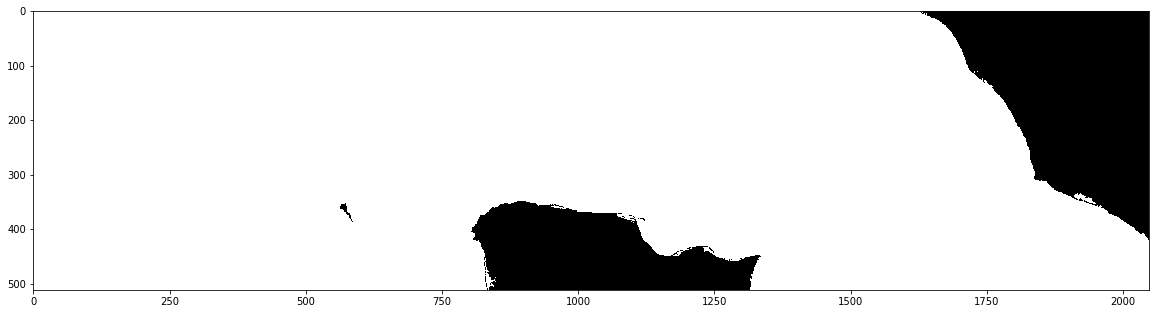

-> output img is: /Users/ehsanmos/Documents/RnD/Ehsan_lab_MISR/img_from_array_dir.nosync/block_5.jpg
-> processing path_num 180, block_num 5
-> total GCPs from img frame: 28
-> found negative long. in coords! will update <-> to <+> long.
-> among neg. longs. we have pos. long.: 177.989362
-> among neg. longs. we have pos. long.: 175.889609
-> among neg. longs. we have pos. long.: 179.876528
-> among neg. longs. we have pos. long.: 177.317271
-> among neg. longs. we have pos. long.: 175.189166
-> among neg. longs. we have pos. long.: 179.215096
-> among neg. longs. we have pos. long.: 176.616710
-> among neg. longs. we have pos. long.: 174.460181
-> among neg. longs. we have pos. long.: 178.835276
-> among neg. longs. we have pos. long.: 176.214992
-> among neg. longs. we have pos. long.: 174.042695
gdalwarp            -r bilinear            -s_srs "EPSG:4326"            -t_srs "EPSG:4326"            -overwrite            -tps            -co TILED=YES            --config CENTER_LONG +18

<Figure size 432x288 with 0 Axes>

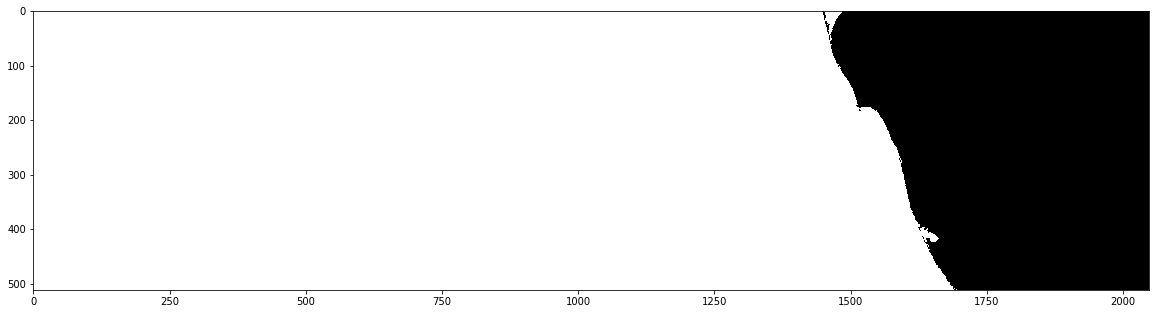

-> output img is: /Users/ehsanmos/Documents/RnD/Ehsan_lab_MISR/img_from_array_dir.nosync/block_4.jpg
-> processing path_num 180, block_num 4
-> total GCPs from img frame: 28
-> found negative long. in coords! will update <-> to <+> long.
-> among neg. longs. we have pos. long.: 179.972659
-> among neg. longs. we have pos. long.: 177.931609
-> among neg. longs. we have pos. long.: 179.372005
-> among neg. longs. we have pos. long.: 177.302417
-> among neg. longs. we have pos. long.: 178.746831
-> among neg. longs. we have pos. long.: 176.648389
-> among neg. longs. we have pos. long.: 178.388752
-> among neg. longs. we have pos. long.: 176.274182
gdalwarp            -r bilinear            -s_srs "EPSG:4326"            -t_srs "EPSG:4326"            -overwrite            -tps            -co TILED=YES            --config CENTER_LONG +180            -srcnodata 0            -dstnodata 0 /Users/ehsanmos/Documents/RnD/Ehsan_lab_MISR/img_from_array_dir.nosync/block_4_translated.tif /Users/ehsan

<Figure size 432x288 with 0 Axes>

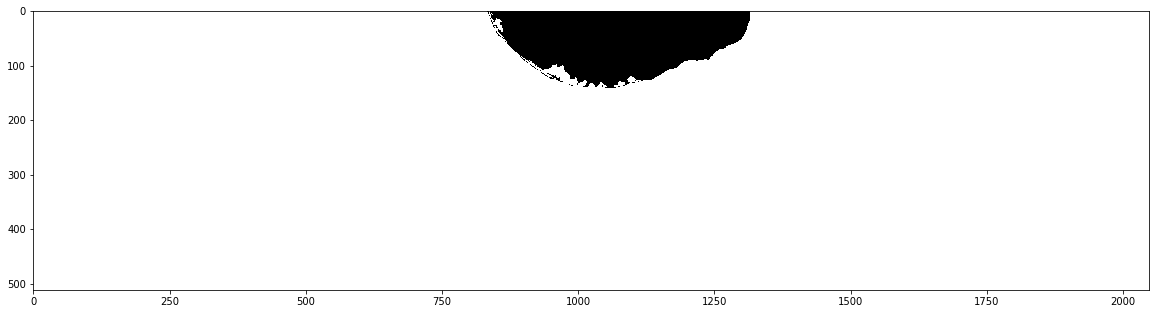

-> output img is: /Users/ehsanmos/Documents/RnD/Ehsan_lab_MISR/img_from_array_dir.nosync/block_6.jpg
-> processing path_num 180, block_num 6
-> total GCPs from img frame: 28
-> found negative long. in coords! will update <-> to <+> long.
-> among neg. longs. we have pos. long.: 178.831812
-> among neg. longs. we have pos. long.: 176.211330
-> among neg. longs. we have pos. long.: 174.038891
-> among neg. longs. we have pos. long.: 178.123109
-> among neg. longs. we have pos. long.: 175.462913
-> among neg. longs. we have pos. long.: 173.262152
-> among neg. longs. we have pos. long.: 179.498492
-> among neg. longs. we have pos. long.: 177.381561
-> among neg. longs. we have pos. long.: 174.681431
-> among neg. longs. we have pos. long.: 172.452580
-> among neg. longs. we have pos. long.: 179.091946
-> among neg. longs. we have pos. long.: 176.955038
-> among neg. longs. we have pos. long.: 174.232705
-> among neg. longs. we have pos. long.: 171.988420
gdalwarp            -r bilinear   

<Figure size 432x288 with 0 Axes>

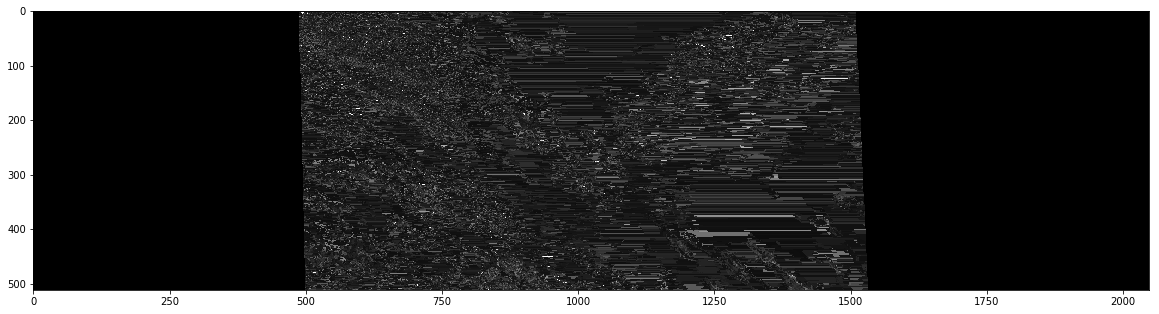

-> output img is: /Users/ehsanmos/Documents/RnD/Ehsan_lab_MISR/img_from_array_dir.nosync/block_7.jpg
-> processing path_num 180, block_num 7
-> total GCPs from img frame: 28
-> found negative long. in coords! will update <-> to <+> long.
-> among neg. longs. we have pos. long.: 179.088234
-> among neg. longs. we have pos. long.: 176.951146
-> among neg. longs. we have pos. long.: 174.228613
-> among neg. longs. we have pos. long.: 171.984189
-> among neg. longs. we have pos. long.: 178.327371
-> among neg. longs. we have pos. long.: 176.153964
-> among neg. longs. we have pos. long.: 173.391471
-> among neg. longs. we have pos. long.: 171.119641
-> among neg. longs. we have pos. long.: 177.528072
-> among neg. longs. we have pos. long.: 175.318042
-> among neg. longs. we have pos. long.: 172.515825
-> among neg. longs. we have pos. long.: 170.217277
-> among neg. longs. we have pos. long.: 177.066866
-> among neg. longs. we have pos. long.: 174.836432
-> among neg. longs. we have pos. 

<Figure size 432x288 with 0 Axes>

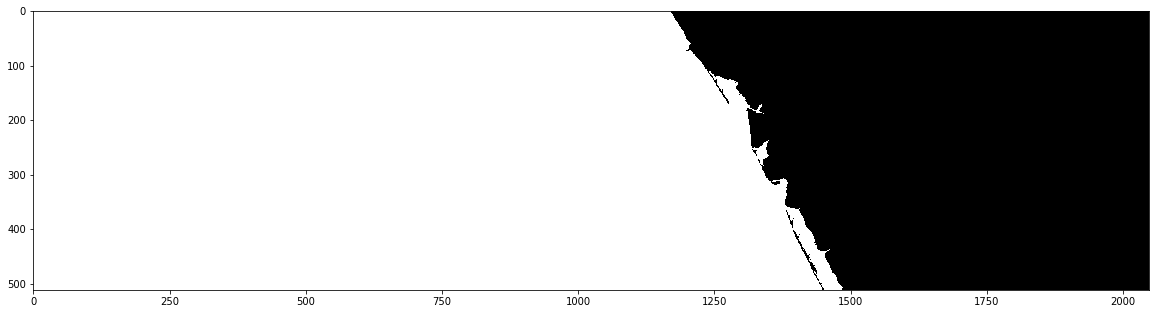

-> output img is: /Users/ehsanmos/Documents/RnD/Ehsan_lab_MISR/img_from_array_dir.nosync/block_3.jpg
-> processing path_num 180, block_num 3
-> total GCPs from img frame: 28
-> found negative long. in coords! will update <-> to <+> long.
-> among neg. longs. we have pos. long.: 179.437951
-> among neg. longs. we have pos. long.: 178.866607
-> among neg. longs. we have pos. long.: 178.273596
-> among neg. longs. we have pos. long.: 179.975603
-> among neg. longs. we have pos. long.: 177.934695
gdalwarp            -r bilinear            -s_srs "EPSG:4326"            -t_srs "EPSG:4326"            -overwrite            -tps            -co TILED=YES            --config CENTER_LONG +180            -srcnodata 0            -dstnodata 0 /Users/ehsanmos/Documents/RnD/Ehsan_lab_MISR/img_from_array_dir.nosync/block_3_translated.tif /Users/ehsanmos/Documents/RnD/Ehsan_lab_MISR/img_from_array_dir.nosync/block_3_reprojected_28GCPs_noRes.tif
-> return stat from subprocess call: 0

-> OK: FINISHED SUCC

<Figure size 432x288 with 0 Axes>

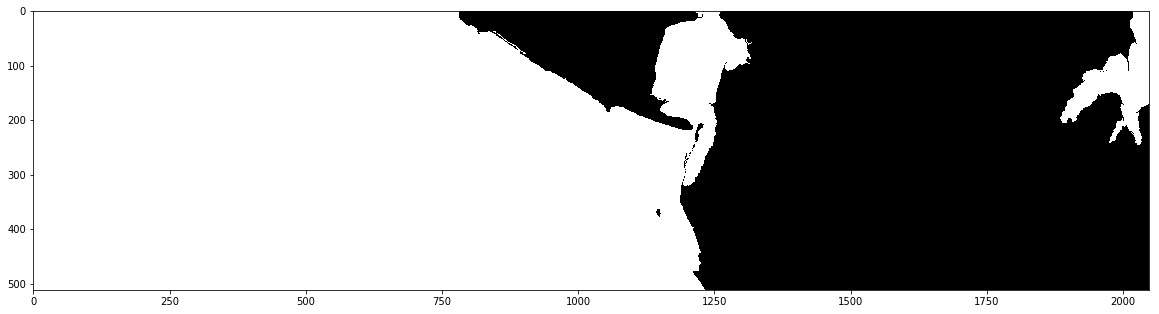

-> output img is: /Users/ehsanmos/Documents/RnD/Ehsan_lab_MISR/img_from_array_dir.nosync/block_2.jpg
-> processing path_num 180, block_num 2
-> total GCPs from img frame: 28
-> found negative long. in coords! will update <-> to <+> long.
-> among neg. longs. we have pos. long.: 179.799413
gdalwarp            -r bilinear            -s_srs "EPSG:4326"            -t_srs "EPSG:4326"            -overwrite            -tps            -co TILED=YES            --config CENTER_LONG +180            -srcnodata 0            -dstnodata 0 /Users/ehsanmos/Documents/RnD/Ehsan_lab_MISR/img_from_array_dir.nosync/block_2_translated.tif /Users/ehsanmos/Documents/RnD/Ehsan_lab_MISR/img_from_array_dir.nosync/block_2_reprojected_28GCPs_noRes.tif
-> return stat from subprocess call: 0

-> OK: FINISHED SUCCESSFULLY! 

-> processing: /Users/ehsanmos/Documents/RnD/Ehsan_lab_MISR/roughness_dir/roughness_P180_O088147_B001.dat
-> roughness img new shape: 512,2048
-> processing block 1


<Figure size 432x288 with 0 Axes>

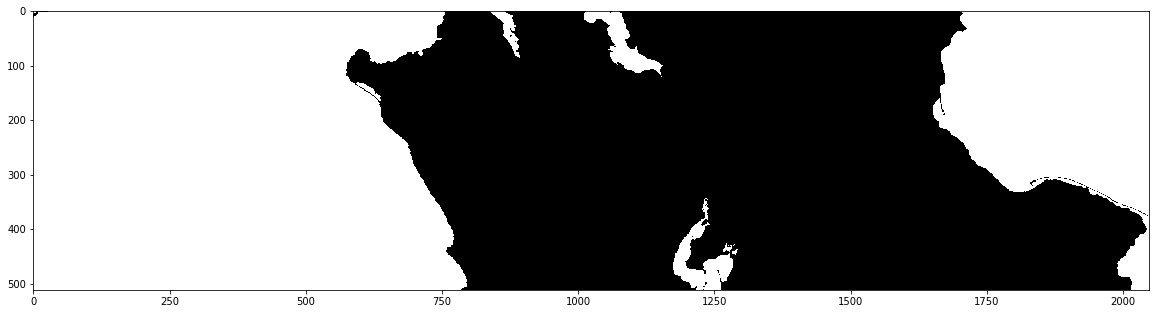

-> output img is: /Users/ehsanmos/Documents/RnD/Ehsan_lab_MISR/img_from_array_dir.nosync/block_1.jpg
-> processing path_num 180, block_num 1
-> total GCPs from img frame: 28
-> found negative long. in coords! will update <-> to <+> long.
gdalwarp            -r bilinear            -s_srs "EPSG:4326"            -t_srs "EPSG:4326"            -overwrite            -tps            -co TILED=YES            --config CENTER_LONG +180            -srcnodata 0            -dstnodata 0 /Users/ehsanmos/Documents/RnD/Ehsan_lab_MISR/img_from_array_dir.nosync/block_1_translated.tif /Users/ehsanmos/Documents/RnD/Ehsan_lab_MISR/img_from_array_dir.nosync/block_1_reprojected_28GCPs_noRes.tif
-> return stat from subprocess call: 0

-> OK: FINISHED SUCCESSFULLY! 



In [19]:
img_dir = "/Users/ehsanmos/Documents/RnD/Ehsan_lab_MISR/img_from_array_dir.nosync"

for rough_fname in roughness_files_fullpath:
    
    print("-> processing: %s" % rough_fname)
    rough_latlon_arr = np.fromfile(rough_fname, dtype='float64')     # is this roughness in cm?
    
    #~ get some info about each array
#     print("-> input file elements: %d" % rough_latlon_arr.size)
#     print("-> input file dim: %d" % rough_latlon_arr.ndim)
#     print("-> input file shape: %s" % rough_latlon_arr.shape)

    #~ get only the roughness values from file, roughness file has roughness-lat-lon in it as a list
    rough_array = rough_latlon_arr[0:1048576]

    #~ create 2D roughness array from list
    rough_array_reshaped = rough_array.reshape((512,2048))

    #~ increase img intensity by 10 to test things
#     rough_array_reshaped = rough_array_reshaped * 10


    print("-> roughness img new shape: %d,%d" % rough_array_reshaped.shape)
    
    
    block_num = rough_fname.split("/")[-1].split("_")[-1].split(".")[0]
    block_num = int(block_num[-1])
    print("-> processing block %s" % (block_num))
    
    
    
    #~ define band and numeric type
    bands_num = 1
    datatype = gdal.GDT_Float32
    raster_EPSG = 4326  
    
    
    ## write img to disc
    img_name = 'block_'+str(block_num)
    img_fullpath = img_show_n_save(rough_array_reshaped, img_name, img_dir)
    
    ## open saved image
    in_ds = gdal.Open(img_fullpath)
    # print(type(in_ds)) # returns a Dataset obj
    
############################################################################################################################

    #~ create list of GCPs 
    
    '''index is useful here, so first we create a list from img coordinates from all img pixels
    then we use the index of each element in the pixel coord list as the index/count of each GCP'''

    print("-> processing path_num %d, block_num %s" %(path_num, block_num))
    #~ make 2 lists for img and geographic frames, then analyze long. to see if all are neg. or all are pos.; if all are the same then pass, else: change <-> to <+>
    pixel_coords_list = []  # (row, column)
    geographic_coord_list = []


    for irow in [0, 200, 400, 511]:
        for jcol in [0, 300, 600, 1000, 1300, 1700, 2047]:

            #~ process each col of each row
    #         print("\n-> processing img coords: (%d, %d)" %(irow, jcol))
            #~ use MTK function to map from img frame to geographic frame
            pixel_coords_tuple = bls_to_latlon(path_num, misr_res_meter, block_num, irow, jcol) # struct=(lat, lon)?
    #         print(pixel_coords_tuple)

            pixel_coords_list.append([irow, jcol])
            geographic_coord_list.append(pixel_coords_tuple)

    print("-> total GCPs from img frame: %d" %len(pixel_coords_list))    
    # print(pixel_coords_list)
    # print(geographic_coord_list)


    #~ check all elements of long. to have same sign, either +/-    
    if (any( [ latlon[1] < 0  for  latlon in geographic_coord_list ] )):  # all(iterable); iterable==list or anything that we can iterate on; Return True if all elements of the iterable are true
        print("-> found negative long. in coords! will update "-" to "+" long.")

        gcp_list = []  # a list of ground control points

        for index, element in enumerate(pixel_coords_list):    # index == each GCP ; element order == [row, col]

            #~ for each point we add GCPs to a list
            gcp_list.append(gdal.GCP())  # initialize GCP dataStruct for each coordinate point

            #~ X,Y in img frame
            gcp_list[index].GCPLine  = pixel_coords_list[index][0]       # y == row
            gcp_list[index].GCPPixel = pixel_coords_list[index][1]       # x == column == pixel


            #~ chnage negative long. to positive w.r.t CENTER_LONG=+180
            #~ print("-> updating neg. lon. to positive")
            #~ add lat
            gcp_list[index].GCPY = geographic_coord_list[index][0]  # lat=northing 

            #~ check for long.
            if ( geographic_coord_list[index][1] < 0 ):
    #             print("-> found neg. long. %f" %geographic_coord_list[index][1])

                updated_long = (360.0 + geographic_coord_list[index][1] )
    #             print("\t-> updated to: %f" %updated_long)

                #~ update neg. long. to pos. long.
                gcp_list[index].GCPX = updated_long

            else:
                print("-> among neg. longs. we have pos. long.: %f" %geographic_coord_list[index][1])

                #~ no need to update since it is pos. long.
                gcp_list[index].GCPX = geographic_coord_list[index][1]


    else:
        ("-> all long. are positive!")

        gcp_list = []  # a list of ground control points

        for index, element in enumerate(pixel_coords_list):    # index == each GCP ; element order == [row, col]

            #~ for each point we add GCPs to a list
            gcp_list.append(gdal.GCP())  # initialize GCP dataStruct for each coordinate point

            #~ X,Y in img frame
            gcp_list[index].GCPLine  = pixel_coords_list[index][0]       # y == row
            gcp_list[index].GCPPixel = pixel_coords_list[index][1]       # x == column == pixel

            #~ add lat&lon
            gcp_list[index].GCPY = geographic_coord_list[index][0]  # lat=northing 
            gcp_list[index].GCPX = geographic_coord_list[index][1]  # lon=easting
            
############################################################################################################################

    #~ gdal.translate to convert data set formats (how input data from memory???)
    #~ write/save image array into raster ??????
    #output_raster.GetRasterBand(bands_num).WriteArray(reversed_arr)

    translated_img = img_name+"_translated.tif"
    out_translated = os.path.join(img_dir, translated_img)


    #~ define Translate Options --> we don't need to create a TranslateOptions object, we only need do define anything as an keyword_argument for the .Translate()
    translate_ds = gdal.Translate(
                                out_translated,
                                in_ds,  
                                format = 'GTiff',
                                outputType = gdal.GDT_Float32,
                                GCPs = gcp_list
                                ) # writes the translated output to a tif file and returns a gdal.Dataset object, after writing the DS will be empty --> how do it VRT???

    # print(type(ds_obj))


    #~ Properly close the datasets to flush to disk
    translate_ds = None
    in_ds = None

############################################################################################################################

    #~ commandLine implementation of gdalwarp, since <--config CENTER_LONG> is not an option for the gdal.Warp() lib. function

    from subprocess import call
    # import os

    total_gcps = len(pixel_coords_list)
    warped_img = img_name+"_reprojected_"+str(total_gcps)+"GCPs_noRes"+".tif"
    out_warped = os.path.join(img_dir, warped_img)

    input_file = out_translated
    output_file = out_warped

    # print(os.path.isfile(out_translated))
    # print(os.path.isfile(out_warped))

    cmd = 'gdalwarp\
            -r bilinear\
            -s_srs "EPSG:4326"\
            -t_srs "EPSG:4326"\
            -overwrite\
            -tps\
            -co TILED=YES\
            --config CENTER_LONG +180\
            -srcnodata 0\
            -dstnodata 0 ' + input_file + ' ' + output_file  #  -tr 0.001 0.001\

    print(cmd)
    #~ note: shell=true to execute the line as full command including arguments
    return_code = call(cmd, shell=True)  # subprocess.call() is better/safer that os.system() ==> finally used os.system() cos call returned error! correct return code?      
    # stat = os.system(input_str_args)  


    print("-> return stat from subprocess call: %d" %return_code)
    print("\n-> OK: FINISHED SUCCESSFULLY! \n")







## look at block 1

In [20]:
# img_name = 'block1'
# img_show_n_save(rough_img_b1, img_name)

## process block-1

In [21]:
# block_num = 1
# print("-> processing block %d" % block_num)

# raster_name = "path_"+str(path_num)+"_block_"+str(block_num)
# raster_fullpath = setup_rastername(raster_dir_fullpath)

# #~ extract block corners clockwize from ulc
# #~ old one that returns 4 corners
# # img_ulc_dd, img_urc_dd, img_lrc_dd, img_llc_dd = extract_block_corners_bls2latlon(path_num, misr_res_meter, block_num, gcp_mode)

# #~ updated one that I modifies for 15 GCPs
# img_ulc_dd, img_urc_dd, img_lrc_dd, img_llc_dd, pixel_coord_list = extract_block_corners_bls2latlon(path_num, misr_res_meter, block_num, gcp_mode)


# #~ setup pixelsize
# pixel_size = setup_pixel_size_new(img_ulc_dd, img_lrc_dd, misr_img_res)

# #~ convert 4 corners from latlon to UTM coords
# # ulc_utm, urc_utm, lrc_utm, llc_utm = latlon2utm(img_ulc_dd, img_urc_dd, img_lrc_dd, img_llc_dd)

# # #~ compute geoTransform from 4 GCPs in UTM coords
# # geoT_fromGCP_UTM = geoTransform_fromGCPs_Ndown(misr_img_res[0], misr_img_res[1], ulc_utm, urc_utm, lrc_utm, llc_utm) 



# #~ compute geoTransform from 4 GCPs in LatLon coords --> for comparison with different methods
# # geoT_fromGCP_latlon, gcp_list = geoTransform_fromGCPs_Ndown(misr_img_res[0], misr_img_res[1], img_ulc_dd, img_urc_dd, img_lrc_dd, img_llc_dd, gcp_mode)

# #~ compute geoTransform from 4 corners in LatLon coords with including rotation and scaling params
# # my_geoT_rot = myGeoTransform_RS(img_ulc_dd, img_urc_dd, img_lrc_dd, img_llc_dd)



# #~ now write array into raster
# #~ with geoTransofmr
# # array2raster_Ndown_ImgTLC(my_geoT_rot, misr_img_res[0], misr_img_res[1], raster_file_fullpath, rough_img_b1, gcp_list) # note: pixel size goes into geoT

# #~ without geoTrans 
# # array2raster_Ndown_ImgTLC(misr_img_res[0], misr_img_res[1], raster_file_fullpath, rough_img_b1, gcp_list) # note: pixel size goes into geoT



# ##############################################################################################
# ### OLD 
# # #~ setup geoTransformation matrix
# # geoT_rotated = geoTransform_fromGCPs_Ndown(misr_img_res[0], misr_img_res[1], img_ulc_dd, img_urc_dd, img_lrc_dd, img_llc_dd) 

# #~ write img as ratser
# #~ use img ulc as raster corner with NorthDown notation
# array2raster_Ndown_withSimpleGeoTransform(img_lrc_dd[1], pixel_size[0], img_lrc_dd[0], pixel_size[1], raster_fullpath, misr_img_res, rough_img_b1) # ulc_lon, w_pixel, ulc_lat, h_pixel



## --> process block-1 with gdal.Translate & .Warp

In [22]:
# block_num = 2
# print("-> processing block %d" % block_num)

# # raster_name = "path_"+str(path_num)+"_block_"+str(block_num)
# # raster_fullpath = setup_rasterfname(raster_dir_fullpath, path_num, block_num)

## process block-1 with GCP method

In [23]:
# #~ define band and numeric type
# bands_num = 1
# datatype = gdal.GDT_Float32
# raster_EPSG = 4326    

## create in-memory dataset

In [24]:
# in_ds = gdal.GetDriverByName('MEM').Create('', misr_img_res[1], misr_img_res[0], bands_num, datatype) # Create('', xcount, ycount, 1, datatype)

# #~ write/save image array into raster
# in_ds.GetRasterBand(bands_num).WriteArray(rough_img_b1)
# print(in_ds)

## write img to disc

In [25]:
# img_name = 'block_'+str(block_num)
# img_dir = "/Users/ehsanmos/Documents/RnD/Ehsan_lab_MISR/img_from_array_dir.nosync"
# img_fullpath = img_show_n_save(rough_img_b2, img_name, img_dir)

## open saved image

In [26]:
## open saved image

in_ds = gdal.Open(img_fullpath)
# print(type(in_ds)) # returns a Dataset obj

## another test to read data from memory

In [27]:
# ds = gdal.Translate('/vsimem/inmem.vrt', in_ds, format='VRT')
# # print(ds)
# print(ds.ReadAsArray().shape)
# # ds = None

In [28]:
#~ input as VRT ????


# #~ Open existing dataset; gdal.open or VRT for gdal.Translate() ???
# in_ds = gdal.Open(rough_img_b1) # or vrt ??? 

## create output .tif driver

In [29]:
# #~ create output format driver, and setup driver=GTiff
# out_format = "GTiff"
# driver = gdal.GetDriverByName(out_format)

# #~ create output raster (img+georefrenced info) dataseet to save/store img data/array into it (raster_fullPath, ncols_rough_arr, nrows_rough_arr, bands, dtype-> GDAL data type arg)
# out_raster = driver.Create(raster_fullpath, bands_num, datatype)
# print(out_raster)

## create list of GCPs 

In [30]:

# '''index is useful here, so first we create a list from img coordinates from all img pixels
# then we use the index of each element in the pixel coord list as the index/count of each GCP'''

# print("-> processing path_num %d, block_num %d" %(path_num, block_num))
# #~ make 2 lists for img and geographic frames, then analyze long. to see if all are neg. or all are pos.; if all are the same then pass, else: change <-> to <+>
# pixel_coords_list = []  # (row, column)
# geographic_coord_list = []


# for irow in [0, 200, 400, 511]:
#     for jcol in [0, 300, 600, 1000, 1300, 1700, 2047]:
        
#         #~ process each col of each row
# #         print("\n-> processing img coords: (%d, %d)" %(irow, jcol))
#         #~ use MTK function to map from img frame to geographic frame
#         pixel_coords_tuple = bls_to_latlon(path_num, misr_res_meter, block_num, irow, jcol) # struct=(lat, lon)?
# #         print(pixel_coords_tuple)
        
#         pixel_coords_list.append([irow, jcol])
#         geographic_coord_list.append(pixel_coords_tuple)
    
# print("-> total GCPs from img frame: %d" %len(pixel_coords_list))    
# # print(pixel_coords_list)
# # print(geographic_coord_list)


# #~ check all elements of long. to have same sign, either +/-    
# if (any( [ latlon[1] < 0  for  latlon in geographic_coord_list ] )):  # all(iterable); iterable==list or anything that we can iterate on; Return True if all elements of the iterable are true
#     print("-> found negative long. in coords! will update <-> to <+> long.")
    
#     gcp_list = []  # a list of ground control points

#     for index, element in enumerate(pixel_coords_list):    # index == each GCP ; element order == [row, col]
        
#         #~ for each point we add GCPs to a list
#         gcp_list.append(gdal.GCP())  # initialize GCP dataStruct for each coordinate point

#         #~ X,Y in img frame
#         gcp_list[index].GCPLine  = pixel_coords_list[index][0]       # y == row
#         gcp_list[index].GCPPixel = pixel_coords_list[index][1]       # x == column == pixel


#         #~ chnage negative long. to positive w.r.t CENTER_LONG=+180
#         #~ print("-> updating neg. lon. to positive")
#         #~ add lat
#         gcp_list[index].GCPY = geographic_coord_list[index][0]  # lat=northing 
        
#         #~ check for long.
#         if ( geographic_coord_list[index][1] < 0 ):
# #             print("-> found neg. long. %f" %geographic_coord_list[index][1])
            
#             updated_long = (360.0 + geographic_coord_list[index][1] )
# #             print("\t-> updated to: %f" %updated_long)
     
#             #~ update neg. long. to pos. long.
#             gcp_list[index].GCPX = updated_long
        
#         else:
#             print("-> among neg. longs. we have pos. long.: %f" %geographic_coord_list[index][1])
     
#             #~ no need to update since it is pos. long.
#             gcp_list[index].GCPX = geographic_coord_list[index][1]
            

# else:
#     ("-> all long. are positive!")
    
#     gcp_list = []  # a list of ground control points

#     for index, element in enumerate(pixel_coords_list):    # index == each GCP ; element order == [row, col]

#         #~ for each point we add GCPs to a list
#         gcp_list.append(gdal.GCP())  # initialize GCP dataStruct for each coordinate point

#         #~ X,Y in img frame
#         gcp_list[index].GCPLine  = pixel_coords_list[index][0]       # y == row
#         gcp_list[index].GCPPixel = pixel_coords_list[index][1]       # x == column == pixel

#         #~ add lat&lon
#         gcp_list[index].GCPY = geographic_coord_list[index][0]  # lat=northing 
#         gcp_list[index].GCPX = geographic_coord_list[index][1]  # lon=easting
    


## gdal.translate to convert data set formats (how input data from memory???)

In [31]:
# ## gdal.translate to convert data set formats (how input data from memory???)

# #~ write/save image array into raster ??????
# #output_raster.GetRasterBand(bands_num).WriteArray(reversed_arr)

# translated_img = img_name+"_translated.tif"
# out_translated = os.path.join(img_dir, translated_img)


# #~ define Translate Options --> we don't need to create a TranslateOptions object, we only need do define anything as an keyword_argument for the .Translate()
# translate_ds = gdal.Translate(
#                             out_translated,
#                             in_ds,  
#                             format = 'GTiff',
#                             outputType = gdal.GDT_Float32,
#                             GCPs = gcp_list
#                             ) # writes the translated output to a tif file and returns a gdal.Dataset object, after writing the DS will be empty --> how do it VRT???

# # print(type(ds_obj))


# #~ Properly close the datasets to flush to disk
# translate_ds = None
# in_ds = None

## gdal.Warp the img == apply crs and GCPs 

In [32]:
# total_gcps = len(pixel_coords_list)
# warped_img = img_name+"_reprojected_"+str(total_gcps)+"GCPs"+".tif"
# out_warped = os.path.join(img_dir, warped_img)


# # OPTS = gdal.WarpOptions(dstSRS='WGS84', options=['CENTER_LONG 180'])

# # warp_ds = gdal.Warp(
# #                     out_warped,
# #                     out_translated,
# #                     format="GTiff",
# #                     resampleAlg="bilinear",
# #                     srcSRS="EPSG:4326",
# #                     dstSRS="EPSG:4326",
# #                     tps=True,        # whether to use Thin Plate Spline GCP transformer
# #                     xRes=0.001,
# #                     yRes=0.001,  # output resolution in target SRS
# #                     srcNodata=0,  # source nodata value(s)
# #                     dstNodata=0,  # output nodata value(s)
# #                     options= OPTS  #["CENTER_LONG +180"]
# #                     ) # note: looks liek by default it overwrites the original image

# # warp_ds = None
# # print("-> OK: ended successfully!")

### commandLine implementation of gdalwarp, since <--config CENTER_LONG> is not an option for the gdal.Warp() lib. function

In [33]:
# ### commandLine implementation of gdalwarp, since <--config CENTER_LONG> is not an option for the gdal.Warp() lib. function

# from subprocess import call
# # import os

# total_gcps = len(pixel_coords_list)
# warped_img = img_name+"_reprojected_"+str(total_gcps)+"GCPs"+".tif"
# out_warped = os.path.join(img_dir, warped_img)

# input_file = out_translated
# output_file = out_warped

# # print(os.path.isfile(out_translated))
# # print(os.path.isfile(out_warped))

# cmd = 'gdalwarp\
#         -r bilinear\
#         -s_srs "EPSG:4326"\
#         -t_srs "EPSG:4326"\
#         -overwrite\
#         -tps\
#         -co TILED=YES\
#         -tr 0.001 0.001\
#         --config CENTER_LONG +180\
#         -srcnodata 0\
#         -dstnodata 0 ' + input_file + ' ' + output_file

# print(cmd)
# #~ note: shell=true to execute the line as full command including arguments
# return_code = call(cmd, shell=True)  # .call is better/safer that os.system() ==> finally used os.system() cos call returned error! correct return code?      
# # stat = os.system(input_str_args)  
           
    
# print("-> return stat from subprocess call: %d" %return_code)
# print("-> OK: ended successfully!")